Description : This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM) to predict the closing stock price of a corporation using the past 60 day stock price.

Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as wb

plt.style.use('fivethirtyeight')
import yfinance as yf
yf.pdr_override()

Getting Stock Prices

In [2]:
start = '2010-01-01'
end = '2019-12-31'

df = wb.get_data_yahoo('AAPL', start, end)

[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.505280,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.516527,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.412874,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.401017,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.443574,447610800


In [4]:
df = df.reset_index()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.505280,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.516527,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.412874,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.401017,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.443574,447610800


In [5]:
df = df.drop(['Date','Adj Close'], axis = 1)
df.head()

,Open,High,Low,Close,Volume
0,7.622500,7.660714,7.585000,7.643214,493729600
1,7.664286,7.699643,7.616071,7.656429,601904800
2,7.656429,7.686786,7.526786,7.534643,552160000
3,7.562500,7.571429,7.466071,7.520714,477131200
4,7.510714,7.571429,7.466429,7.570714,447610800


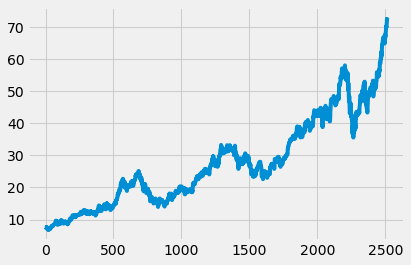

In [6]:
plt.plot(df.Close)

### Moving Average

In [7]:
ma100 = df.Close.rolling(100).mean()
ma100

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
2510    59.201075
2511    59.401700
2512    59.643125
2513    59.875125
2514    60.106325
Name: Close, Length: 2515, dtype: float64

First 100 values will be 0 since 100 day average can not be taken before 100 days.

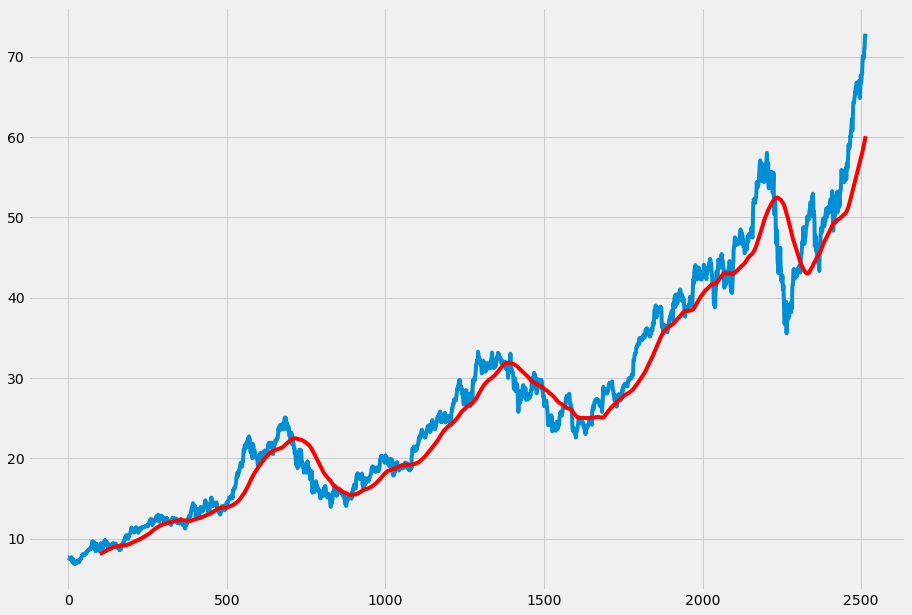

In [8]:
plt.figure(figsize=(14,10))
plt.plot(df.Close)
plt.plot(ma100,'r')

In [9]:
def moving_avg(days):
    ma = df.Close.rolling(days).mean()
    return ma

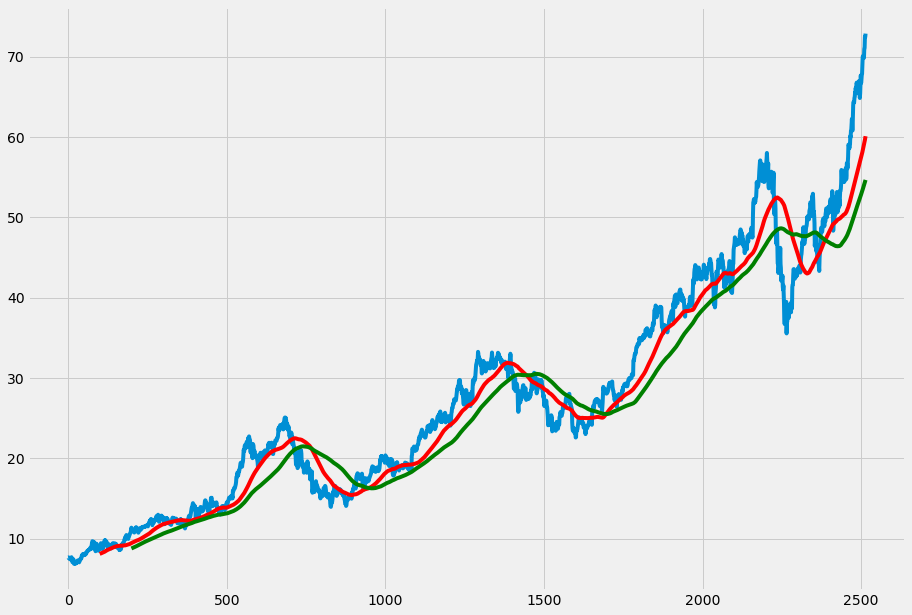

In [10]:
ma200 = moving_avg(200)  #200 day moving average
plt.figure(figsize=(14,10))
plt.plot(df.Close)
plt.plot(ma100,'r')
plt.plot(ma200,'g')

- When the 100 day moving average is above the 200 day moving average, then there is an up trend. 
- When the 100 day MA crosses the 200 day MA, if it is below the 200 day MA then it shows a down trend and vice versa.

In [11]:
df.shape

(2515, 5)

Splitting data into training and testing

In [12]:
data_training = pd.DataFrame(df['Close'][0:int(len(df['Close'])*0.7)])
data_testing = pd.DataFrame(df['Close'][int(len(df['Close'])*0.7):int(len(df['Close']))])

print(data_training.shape)
print(data_testing.shape)

(1760, 1)
(755, 1)


In [13]:
data_training.head()

,Close
0,7.643214
1,7.656429
2,7.534643
3,7.520714
4,7.570714


Scaling the data because we can't provide this input to a LSTM model

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [15]:
data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[0.02971782],
       [0.03021854],
       [0.02560389],
       ...,
       [0.84388656],
       [0.85089656],
       [0.84616011]])

In [16]:
x_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[(i-100):i])
    y_train.append(data_training_array[i,0])

x_train, y_train = np.array(x_train) ,np.array(y_train)

In [17]:
x_train.shape

(1660, 100, 1)

ML Model

In [18]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout

In [19]:
model = Sequential()
model.add(LSTM(units = 50, activation= 'relu', return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation= 'relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation= 'relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation= 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [43]:
model.compile(optimizer='adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 50)

Epoch 1/50
52/52 [==============================] - 26s 290ms/step - loss: 0.0683
Epoch 2/50
52/52 [==============================] - 15s 296ms/step - loss: 0.0128
Epoch 3/50
52/52 [==============================] - 15s 293ms/step - loss: 0.0112
Epoch 4/50
52/52 [==============================] - 15s 293ms/step - loss: 0.0091
Epoch 5/50
52/52 [==============================] - 15s 296ms/step - loss: 0.0090
Epoch 6/50
52/52 [==============================] - 15s 296ms/step - loss: 0.0099
Epoch 7/50
52/52 [==============================] - 16s 310ms/step - loss: 0.0094
Epoch 8/50
52/52 [==============================] - 16s 299ms/step - loss: 0.0070
Epoch 9/50
52/52 [==============================] - 25s 479ms/step - loss: 0.0072
Epoch 10/50
52/52 [==============================] - 22s 412ms/step - loss: 0.0075
Epoch 11/50
52/52 [==============================] - 22s 420ms/step - loss: 0.0071
Epoch 12/50
52/52 [==============================] - 22s 429ms/step - loss: 0.0073
Epoch 13/50
5

In [44]:
model.save('keras_model.h5')

In [21]:
from tensorflow import keras
loaded_model = keras.models.load_model('keras_model.h5')

In [22]:
data_testing.head()

,Close
1760,29.182501
1761,28.955000
1762,29.037500
1763,29.004999
1764,29.152500


In order to predict the value corresponding to the index of 1760, we need past 100 days of data which are the last 100 values of the training data.

In [23]:
past_100_days = data_training.tail(100)

In [24]:
final_df = past_100_days.append(data_testing, ignore_index=True)

In [25]:
final_df.head()

,Close
0,27.092501
1,27.202499
2,27.000000
3,26.982500
4,27.045000


In [26]:
input_data = scaler.fit_transform(final_df)
input_data

array([[0.02781467],
       [0.03015022],
       [0.02585064],
       [0.02547908],
       [0.02680611],
       [0.03370671],
       [0.03317586],
       [0.03232658],
       [0.03158344],
       [0.03306972],
       [0.02855781],
       [0.03036255],
       [0.02600988],
       [0.02356814],
       [0.02022403],
       [0.01958704],
       [0.01523437],
       [0.01576518],
       [0.01910933],
       [0.02441747],
       [0.02425819],
       [0.02776158],
       [0.01268645],
       [0.        ],
       [0.01226183],
       [0.02558522],
       [0.04586231],
       [0.06603324],
       [0.06258295],
       [0.05547006],
       [0.05541697],
       [0.05531082],
       [0.06099053],
       [0.05085197],
       [0.05175434],
       [0.05286905],
       [0.05743405],
       [0.04803866],
       [0.05265676],
       [0.04984341],
       [0.05239133],
       [0.05265676],
       [0.05711557],
       [0.05801795],
       [0.06858117],
       [0.0699082 ],
       [0.07542863],
       [0.073

In [27]:
input_data.shape

(855, 1)

In [28]:
x_test = []
y_test = []

for i in range(100,input_data.shape[0]):
    x_test.append(input_data[i-100:i])
    y_test.append(input_data[i, 0])


x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(755, 100, 1)
(755,)


Making Predictions

In [37]:
y_predicted = loaded_model.predict(x_test)

24/24 [==============================] - 3s 119ms/step


In [38]:
y_predicted.shape

(755, 1)

In [39]:
scaler.scale_  #Gives the factor by which the model is scaled

array([0.02123255])

In [40]:
scale_factor = 1/scaler.scale_
scale_factor

array([47.09749794])

In [41]:
y_predicted = scale_factor*y_predicted

In [42]:
y_test = scale_factor*y_test

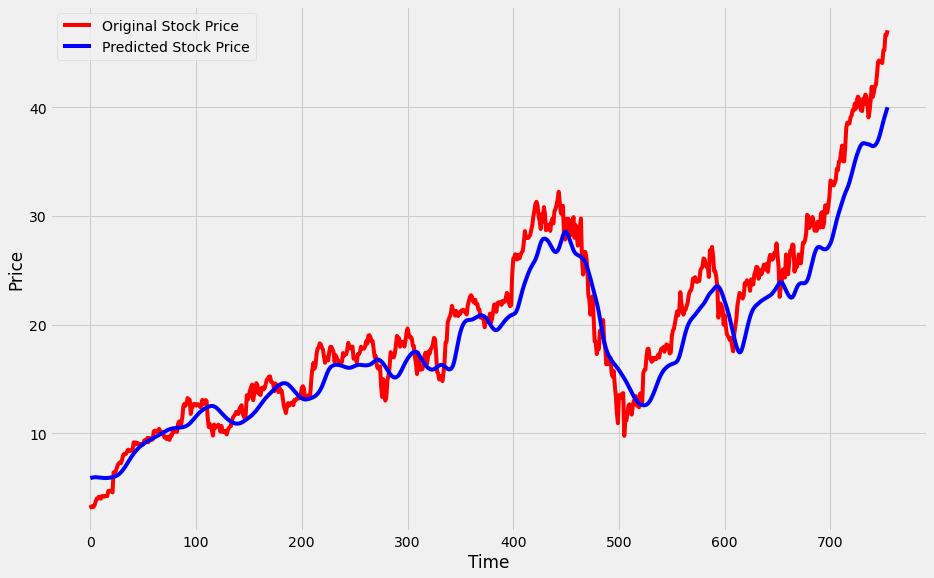

In [48]:
plt.figure(figsize=(14,9))
plt.plot(y_test,"r",label = "Original Stock Price")
plt.plot(y_predicted,"b",label = "Predicted Stock Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()